<a href="https://colab.research.google.com/github/viswanath0408/Cookbook/blob/master/%5BSD_2025%5D_Lab_1_LLM_Prompting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-On Session 1: The Art of Prompting LLMs

## Overview

Welcome to Part 1(a) of our AI workshop series. In this session, you'll dive into the world of prompting large language models (LLMs), gaining some initial familiarity with effectively communicating with LLMs.

## Learning Objectives
By the end of this lab, you will:
1. Craft effective prompts for diverse AI applications
2. Understand and apply various prompting techniques
3. Gain insights into AI safety through hands-on experience

## 0. Using the tech stack

* **Google Colab**: We'll use this free, cloud-based platform for easy setup and access to computational resources. While we're focusing on Colab, you can easily replicate this project in your local computing environment. (You're here!)
* To run "cells" in Colab, either press the "Play" button in the upper left of the cell, or type Shift+Enter (hold down the keys together briefly).

* **LiteLLM**: This library helps streamline interactions with a wide range of pre-trained LLMs. We'll use it to load and run our LLMs, and interact with the LLM.

* **LLM**: We'll start with a handful of OpenAI and Gemini models.

____
## LAB 1-A: Prompting Fundamentals

For this hands-on session, we will explore:

- **Prompt Anatomy**: Explore system instructions, user inputs, and AI responses.
- **Token Mechanics**: Understand what tokens are, how they are used in LLMs, and how to estimate both input and output costs of token use.
- **Conversation Dynamics**: Compare single-turn queries and multi-turn dialogues.

To begin, we need to install litellm in order to have a simple, unified interface to communicate with an LLM

In [ ]:
#@title Installing Necessary Packages and Imports
%%capture
%pip install litellm ipydatagrid

import gdown
import os
import litellm
litellm.drop_params = True

from litellm import completion
from litellm import model_cost
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output
from collections import defaultdict
from ipydatagrid import DataGrid
from google.colab import output
output.enable_custom_widget_manager()

# File ID from Google Drive link
file_id = '1fHsWJRXEJVL3PPYhNuCYklIhNHAJXnYE'
destination = '/content/env_vars.txt'

# Download the file from Google Drive
gdown.download(f'https://drive.google.com/uc?id={file_id}', destination, quiet=False)

# Read the file and set environment variables
with open(destination, 'r') as file:
    exec(file.read())


AttributeError: 'CapturingDisplayPublisher' object has no attribute 'register_hook'

In [ ]:
#@title Extract relevant available models given a few constraints

def filter_models_by_cost_and_provider(acceptable_providers: list, mode: str, max_input_cost_per_token_million: float, max_output_cost_per_token_million: float, structured_responses: bool) -> dict:
    """
    Filters models from the global model_cost dictionary based on acceptable providers and max token costs.

    Args:
        acceptable_providers: A list of strings representing the acceptable providers.
        mode: The mode of the model. (chat, embedding, etc. Based on LiteLLM)
        max_input_cost_per_token_million: The maximum acceptable input cost per token (in dollars per million tokens).
        max_output_cost_per_token_million: The maximum acceptable output cost per token (in dollars per million tokens).
        structured_responses: A boolean indicating whether we want the model to support structured responses

    Returns:
        A dictionary where keys are provider names and values are lists of model information
        dictionaries that meet the specified criteria, including their blended token cost.
    """
    filtered_models = defaultdict(list)
    for model_name, model_info in model_cost.items():
        provider = model_info.get('litellm_provider')
        input_cost_per_token = model_info.get('input_cost_per_token', 0)
        output_cost_per_token = model_info.get('output_cost_per_token', 0)
        model_mode = model_info.get('mode')
        supports_response_schema = model_info.get('supports_response_schema', False)
        supported_output_modalities = model_info.get('supported_output_modalities', [])

        if structured_responses and not supports_response_schema:
            continue

        # Convert cost per token to cost per million tokens for comparison
        input_cost_per_token_million = round(input_cost_per_token * 1_000_000, 4)
        output_cost_per_token_million = round(output_cost_per_token * 1_000_000, 4)

        # Calculate blended cost (simple average for now)
        blended_cost_per_token_million = round((input_cost_per_token_million + output_cost_per_token_million) / 2, 4)
        if blended_cost_per_token_million == 0 or model_mode != mode:
            continue
        if provider in acceptable_providers and \
            input_cost_per_token_million <= max_input_cost_per_token_million and \
            output_cost_per_token_million <= max_output_cost_per_token_million:
            # Include all model_info and the blended cost
            model_info_with_cost = model_info.copy()
            model_info_with_cost['blended_cost_per_token_million'] = blended_cost_per_token_million
            # Additional filtering for openai models based on supported_output_modalities
            if provider == 'openai':
                if 'text' not in supported_output_modalities:
                  continue
            if provider == 'gemini':
              ### Skipping the below two models due to issues
              if model_name in ["gemini/gemini-1.5-flash-001", "gemini/gemini-2.0-flash-preview-image-generation"]:
                continue
              ### Small filter on requests per minute just to reduce returned list a bit.
              if model_info['rpm'] < 100:
                continue
            filtered_models[provider].append({model_name: model_info_with_cost})


    return filtered_models

available_models = filter_models_by_cost_and_provider(acceptable_providers=['openai', 'gemini'],
                                                      mode='chat',
                                                      max_input_cost_per_token_million=3,
                                                      max_output_cost_per_token_million=3,
                                                      structured_responses=True)

### Create a simple LLM

---
Now let's try making a very simple LLM, technically a text-completion model.

In [ ]:
# Define the model options and sort them
sorted_models_list = []
for provider in ['gemini', 'openai']:
    if provider in available_models:
        provider_models = sorted([list(model.keys())[0] for model in available_models[provider]])
        sorted_models_list.extend(provider_models)

all_models_list = sorted_models_list


# Create the dropdown widget
model_dropdown = widgets.Dropdown(
    options=['Select a model'] + all_models_list,
    value='Select a model',
    description='Model:',
    disabled=False,
)

# Create a text input widget for the prompt
input_text = widgets.Textarea(
    value='What is the elevation of Mount Kilimanjaro?',
    placeholder='Enter your prompt here',
    description='Prompt:',
    layout=widgets.Layout(width='50%', height='100px') ,
    disabled=False
)

# Create a button
submit_button = widgets.Button(description="Submit")


# Output widget to display the table and responses
output_area = widgets.Output()

# Display the output area for the table and responses
display(output_area)

# Function to display model comparison table
def display_model_comparison_table(models_dict):
    data = []
    # Collect data and sort it
    for provider, models_info in models_dict.items():
        for model_data in models_info:
            for model_name, info in model_data.items():
                data.append({
                    'Provider': provider,
                    'Model Name': model_name,
                    'Input Cost (per million tokens)': round(info.get('input_cost_per_token', 0) * 1_000_000, 4),
                    'Output Cost (per million tokens)': round(info.get('output_cost_per_token', 0) * 1_000_000, 4),
                    'Blended Cost (per million tokens)': info.get('blended_cost_per_token_million', 0),
                    'Supports Response Schema': info.get('supports_response_schema', False),
                    'Supports Vision': info.get('supports_vision', False),
                    'Supports Function Calling': info.get('supports_function_calling', False),
                    'RPM (Requests Per Minute)': info.get('rpm', 'N/A'),  # Add RPM
                    'TPM (Tokens Per Minute)': info.get('tpm', 'N/A')    # Add TPM
                })

    if data:
        df = pd.DataFrame(data)
        df_sorted = df.sort_values(by=['Provider', 'Model Name']).reset_index(drop=True)
        with output_area:
            clear_output(wait=True)
            grid = DataGrid(df_sorted)
            grid.auto_fit_columns=True
            display(grid)
        return df_sorted
    else:
        with output_area:
            clear_output(wait=True)
            print("No models available based on the current filter.")
        return None


# Display the initial table
available_models_df = display_model_comparison_table(available_models)

# Arrange dropdown, input text and button vertically below the table
input_widgets = widgets.VBox([model_dropdown, input_text, submit_button])
display(input_widgets)


# Function to handle button click
def on_submit_button_clicked(b):
    selected_model = model_dropdown.value
    user_prompt = input_text.value

    if selected_model == "Select a model":
        with output_area:
            print("Please select a model.")
        return
    if not user_prompt:
        with output_area:
            print("Please enter a prompt.")
        return

    messages = [{"content": user_prompt, "role": "user"}]

    with output_area:
        clear_output(wait=True)
        print(f"Selected model: {selected_model}")
        print("Sending API call...")
        try:
            response = completion(model=selected_model, messages=messages)
            display(Markdown(response.choices[0].message.content))
        except Exception as e:
            print(f"An error occurred: {e}")


# Register the callback function
submit_button.on_click(on_submit_button_clicked)

Output()

For those who want to peer a little bit deeper into the response object, take a look at the output from the below cell. Notice a few things:
1. Although we selected gpt-5-nano, the model that was actually used was gpt-5-nano-2025-08-07. **This indicates that the gpt-5-nano model is really just a pointer to most likely the latest version of the model**.
2. Gpt-5-nano also used a few hundred reasoning_tokens for internal "thinking" before producing the final answer. This shows the model's chain-of-thought reasoning process that happens behind the scenes. This is a controlled parameter, but not available for older models.
3. If you had any tools used, like a web search, or a document lookup, it would appear here under your tool_calls field.


```python
user_prompt = "What is the elevation of Mount Kilimanjaro?"

messages = [{"content": user_prompt, "role": "user"}]

response = completion(model='gpt-5-nano', messages=messages)

print(response.model_dump_json(indent=2))
```
```json
{
  "id": "chatcmpl-C6q45tUmRdFjIARARVGyuhlLKTKdB",
  "created": 1755746141,
  "model": "gpt-5-nano-2025-08-07",
  "object": "chat.completion",
  "system_fingerprint": null,
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "Approximately 5,895 meters (19,341 feet) above sea level. The summit is Uhuru Peak.",
        "role": "assistant",
        "tool_calls": null,
        "function_call": null,
        "annotations": []
      },
      "provider_specific_fields": {}
    }
  ],
  "usage": {
    "completion_tokens": 352,
    "prompt_tokens": 17,
    "total_tokens": 369,
    "completion_tokens_details": {
      "accepted_prediction_tokens": 0,
      "audio_tokens": 0,
      "reasoning_tokens": 320,
      "rejected_prediction_tokens": 0,
      "text_tokens": null
    },
    "prompt_tokens_details": {
      "audio_tokens": 0,
      "cached_tokens": 0,
      "text_tokens": null,
      "image_tokens": null
    }
  },
  "service_tier": "default"
}
```


**Congratulations**, you just created & programmatically interacted with your first LLM. 🎉



### Task 1

Enter a new "prompt_factoid" below to test the LLM's responses.

Try:

*   Changing the question to a different 'factoid';
*   Asking a more open-ended question;
*   Asking a more business-specific question.


*You can also go back to the previous code above and change the LLM model! Notice how the same prompt can have significantly different responses.*


In [ ]:
llm_model = "gemini/gemini-2.0-flash" #@param ['gemini/gemini-1.5-flash', 'gemini/gemini-1.5-flash-002', 'gemini/gemini-1.5-flash-latest', 'gemini/gemini-2.0-flash', 'gemini/gemini-2.0-flash-001', 'gemini/gemini-2.0-flash-lite', 'gemini/gemini-2.0-flash-lite-preview-02-05', 'gemini/gemini-2.5-flash', 'gpt-4.1-mini', 'gpt-4.1-mini-2025-04-14', 'gpt-4.1-nano', 'gpt-4.1-nano-2025-04-14', 'gpt-5-mini', 'gpt-5-mini-2025-08-07', 'gpt-5-nano', 'gpt-5-nano-2025-08-07']

user_prompt = "Tell me a funny joke" # @param {"type":"string","placeholder":"Tell me a joke"}

messages = [{"content": user_prompt, "role": "user"}]

print("Sending API call...")
response = completion(model=llm_model,
                      messages=messages,
                      temperature=0.3)
display(Markdown(response.choices[0].message.content))


Sending API call...


Why don't scientists trust atoms?

Because they make up everything!


**PAUSE** here. Did you do the task above? What did you learn?

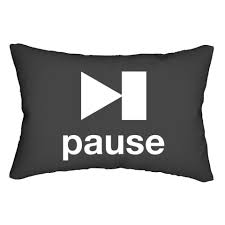

## Create a Chat LLM
---
Now let's try creating a slightly-more sophisticated model, a Chat LLM.

What makes a chat model different from another LLM? A Chat LLM can engage in dialogue, going back & forth with the user, unlike a text-completion LLM which responds (once) to a (single) prompt. Therefore, we'll have to create a slightly more complex set of prompts to interact with the model, including System Messages and User (or Human) Messages.

### Prompt Anatomy

We usually think of a "prompt" as a simple piece of text that we send to a model, as we have been doing thus far. But prompts can include more than that. For example, they might include **system instructions** (like, "Act as an expert in Python programming") or different **parameters** like temperature to control randomness.

There are three types of messages with an LLM:

* **system messages** describe the behavior of the AI assistant. A useful system message for data science use cases is "You are a helpful assistant who understands data science."
* **user messages** describe what you want the AI assistant to say. We'll cover examples of user messages throughout this tutorial
* **assistant messages** describe previous responses in the conversation. We'll cover how to have an interactive conversation later in this lab.

The first message should be a system message. Additional messages should alternate between the user and the assistant.

Let's create a chat LLM, then be a little more specific about our prompts to it.

In [ ]:
# Feel free to select a new LLM from our list.
llm_model = "gemini/gemini-2.0-flash" #@param ['gemini/gemini-1.5-flash', 'gemini/gemini-1.5-flash-002', 'gemini/gemini-1.5-flash-latest', 'gemini/gemini-2.0-flash', 'gemini/gemini-2.0-flash-001', 'gemini/gemini-2.0-flash-lite', 'gemini/gemini-2.0-flash-lite-preview-02-05', 'gemini/gemini-2.5-flash', 'gpt-4.1-mini', 'gpt-4.1-mini-2025-04-14', 'gpt-4.1-nano', 'gpt-4.1-nano-2025-04-14', 'gpt-5-mini', 'gpt-5-mini-2025-08-07', 'gpt-5-nano', 'gpt-5-nano-2025-08-07']

# Define the system message
SYSTEM_MESSAGE = 'You are a helpful assistant who understands the business of interior decorating.'

# Define the user message
USER_MESSAGE = 'What color paint should I use for a living room in a house on the beach in San Diego?'

messages_chat = [
    {"content": SYSTEM_MESSAGE, "role": "system"},
    {"content": USER_MESSAGE, "role": "user"}
]

### Note: We can add streaming in order to help with seeing the initial outputs sooner.
response = completion(model=llm_model, messages=messages_chat, temperature=1, stream=True)
res_so_far = ""
for part in response:
  if part.choices[0].delta.content:
    res_so_far += part.choices[0].delta.content
  print(res_so_far)
  clear_output(wait=True)

KeyboardInterrupt: 

In [ ]:
display(Markdown(res_so_far))

Okay, a beach house in San Diego! That sounds lovely. When choosing a paint color for your living room, several factors come into play to create that perfect coastal vibe. Here are some popular paint color directions, along with some specific suggestions, and things to consider:

**Overall Goals & Considerations:**

*   **Light and Airy:** Beach houses generally benefit from feeling light and airy, maximizing the natural light and reflecting the outdoors.
*   **Coastal Vibe:** Think about the specific type of coastal vibe you want. Is it a bright, breezy, classic beach look? A more sophisticated, muted coastal style? Or a warmer, more bohemian beach feel?
*   **Existing Elements:** Consider existing furniture, flooring, and architectural details (like trim). You want the paint to complement, not clash. Are there any prominent colors in your furniture or decor that you want to play off of?
*   **Natural Light:** San Diego has great sunlight, but consider the *direction* the windows face. A north-facing room might need warmer tones to compensate for cooler light, while a south-facing room can handle cooler colors.
*   **Size of the Room:** Lighter colors will make a smaller room feel bigger.

**Color Palette Options & Specific Paint Color Suggestions:**

Here are some popular paint color directions for beach living rooms, along with specific color suggestions from popular brands (but always test samples in your space!):

**1. Classic Coastal (Light & Breezy):**

*   **Goal:** Creates a clean, fresh, and inviting space. This is a very popular and versatile option.
*   **Colors:** Primarily whites, off-whites, and very pale blues or greens. Think of sand, seafoam, and clouds.
*   **Suggestions:**
    *   **Benjamin Moore "White Dove" (OC-17):** A classic, soft white that works well in almost any light.
    *   **Sherwin-Williams "Sea Salt" (SW 6204):** A very popular, soft, muted green-blue that evokes the ocean.
    *   **Benjamin Moore "Cloud White" (OC-130):** A warmer white that is soft and inviting.
    *

**Congratulations**, you just created & programmatically interacted with your first chat LLM. 🎉

### Task 2

Try setting a different `SYSTEM_MESSAGE` variable in the below cell and see how it impacts the response.

Try:

*   Changing the role of the system;
*   Setting a "stylized" response for the system (e.g.: 'in the style of Gandalf from The Hobbit');
*   Etc.


In [ ]:
# Define the system message
SYSTEM_MESSAGE = "Enter a new system message! Something like 'You are a lazy hourly worker at a paint store' or Respond in the style of Gandalf from The Hobbit" #@param {"type": "string"}

# Define the user message
USER_MESSAGE = 'What color paint should I use for a living room in a house on the beach in San Diego?'

messages_chat = [
    {"content": SYSTEM_MESSAGE, "role": "system"},
    {"content": USER_MESSAGE, "role": "user"}
]

### Note: We can add streaming in order to help with seeing the initial outputs sooner.
response = completion(model=llm_model, messages=messages_chat, temperature=1)
display(Markdown(response.choices[0].message.content))

**Option 1: The Laid-Back Beach Bum (lazy hourly worker at a paint store)**

Ugh, another customer... Look, pal, just grab some white. Everyone wants white for a beach house. It's easy, it's bright, it goes with everything. We got like, five different whites here. Just pick one, I don't care. Maybe "Seashell White" if you want to sound fancy. Just get out of here so I can get back to my phone.

**Option 2: The Gandalf the Grey (from The Hobbit)**

Ah, a question of color, a question of light and shadow! For a living room by the shores of San Diego, where the sun dances upon the waves like diamonds, I would advise thee to consider the spirit of the sea itself.

A soft, gentle grey, like the mist that rises from the ocean at dawn, could bring a sense of peace and tranquility. Or perhaps a warm, sandy beige, reminiscent of the dunes where the sea oats sway in the wind. These colours would capture the essence of the coast and reflect the natural light in a harmonious way.

But be warned, choosing the right colour is not merely a matter of aesthetics. It is a matter of evoking the very soul of the place. Consider the furnishings, the light, and the spirit you wish to create within those walls. For even the smallest of choices can have a great impact on the journey that lies ahead.


**PAUSE** here. Did you do the task above? What did you learn?

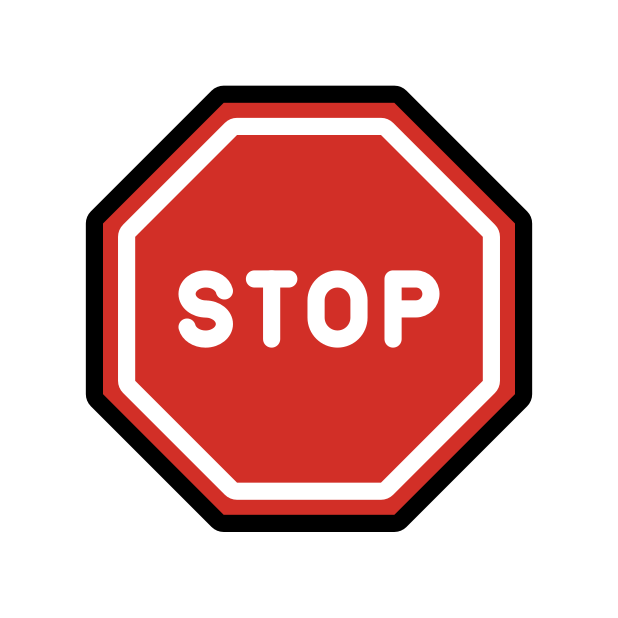

**STOP** here - end of Lab 1-A.

## LAB 1-B Complex Prompting

### Prompt Templates

Our prompts are starting to get a little complicated, with different types of messages and enforced order.

Let's explore the use of a "**prompt template**" to help with all of this, giving us a structured starting point for our prompts to pass to the chat *LLM*.

In [ ]:
from typing import List, Dict
import pydantic

class SimplePromptTemplate(pydantic.BaseModel):
    city: str

    def format_string(self) -> str:
        return f"What color paint should I use for a house in {self.city}."


In [ ]:
# Provide the value for the placeholder to create the prompt
City = "San Diego" #@param {"type": "string"}
filled_prompt = SimplePromptTemplate(city=City.strip()).format_string()
print(filled_prompt)

What color paint should I use for a house in San Diego.


In [ ]:
# Define the system message
SYSTEM_MESSAGE = 'You are a helpful assistant who understands the business of interior decorating.'

messages_chat = [
    {"content": SYSTEM_MESSAGE, "role": "system"},
    {"content": filled_prompt, "role": "user"}
]

### Note: We can add streaming in order to help with seeing the initial outputs sooner.
response = completion(model=llm_model, messages=messages_chat, temperature=1)
display(Markdown(response.choices[0].message.content))

Okay, let's talk paint colors for a house in San Diego!  Here's a breakdown to help you choose the perfect palette, considering the local environment and style:

**Key Considerations for San Diego:**

*   **Sunlight:** San Diego gets a lot of sunshine! This means colors will appear brighter and lighter than they would in a less sunny area. Consider how the light hits your house at different times of day.
*   **Coastal Influence:** Many San Diego homes embrace a coastal vibe. This often translates to lighter, airier colors that evoke the ocean and sky.
*   **Architectural Style:**  The style of your house matters.  Is it a Craftsman bungalow, a Spanish Colonial, a modern beach house, or something else? The paint color should complement the architecture.
*   **HOA Restrictions:** If you're in a neighborhood with a Homeowners Association (HOA), check their guidelines before committing to a color.
*   **Personal Preference:** Ultimately, you need to love the colors you choose!

**Popular Color Palettes for San Diego Homes:**

**1. Coastal/Beach-Inspired:**

*   **Whites and Off-Whites:**  Classic, clean, and reflect light beautifully.
    *   Examples: Benjamin Moore White Dove, Sherwin-Williams Alabaster, Dunn-Edwards Swiss Coffee.
    *   **Why:** Versatile, creates a bright and airy feel, works well with any accent color.
*   **Light Blues and Greens:** Evoke the ocean and sky.
    *   Examples: Sherwin-Williams Sea Salt, Benjamin Moore Palladian Blue, Dunn-Edwards Crystal Springs.
    *   **Why:** Relaxing, refreshing, complements natural landscapes.
*   **Sandy Beiges and Taupes:**  Warm and natural, reminiscent of the beach.
    *   Examples: Sherwin-Williams Accessible Beige, Benjamin Moore Edgecomb Gray, Dunn-Edwards Warm White.
    *   **Why:** Earthy, grounding, creates a cozy feel.
*   **Accents:** Consider pops of coral, navy blue, turquoise, or yellow for doors, shutters, or trim.

**2. Earthy/Mediterranean:**

*   **Warm Whites and Creams:** Soft and inviting.
    *   Examples: Benjamin Moore Navajo White, Sherwin-Williams Creamy, Dunn-Edwards Bone White.
    *   **Why:** Creates a warm and welcoming atmosphere, complements terracotta tiles and stucco.
*   **Terracotta and Clay Tones:**  Rich and grounding.
    *   Examples: Sherwin-Williams Baked Clay, Benjamin Moore Terra Cotta Tile, Dunn-Edwards Adobe Villa.
    *   **Why:** Adds warmth and depth, evokes a Spanish Colonial or Mediterranean feel.
*   **Olive Greens:**  Natural and calming.
    *   Examples: Sherwin-Williams Dried Thyme, Benjamin Moore Olive Branch, Dunn-Edwards Olive Tree.
    *   **Why:** Complements terracotta and warm whites, adds a touch of nature.
*   **Accents:**  Deep blues, wrought iron black, or vibrant reds for a pop of color.

**3. Modern/Contemporary:**

*   **Cool Grays:**  Sophisticated and versatile.
    *   Examples: Sherwin-Williams Repose Gray, Benjamin Moore Gray Owl, Dunn-Edwards Foggy Day.
    *   **Why:** Creates a clean and modern look, works well with bold accents.
*   **Charcoal Grays and Blacks:**  Dramatic and stylish.
    *   Examples: Sherwin-Williams Iron Ore, Benjamin Moore Kendall Charcoal, Dunn-Edwards Black Pool.
    *   **Why:** Adds contrast and depth, perfect for accent walls or modern exteriors.
*   **Bright Whites:**  Minimalist and clean.
    *   Examples: Sherwin-Williams Pure White, Benjamin Moore Chantilly Lace, Dunn-Edwards Cool December.
    *   **Why:** Creates a bright and airy feel, emphasizes architectural details.
*   **Accents:**  Bold colors like orange, yellow, or teal for doors or architectural features.

**Tips for Choosing Paint Colors:**

*   **Get Samples:** Always, always, always get paint samples and test them on your walls. Observe how the colors look at different times of day and in different lighting conditions.
*   **Consider Undertones:**  Pay attention to the undertones of the paint.  Gray can have blue, green, or purple undertones, and beige can have pink or yellow undertones.  Choose undertones that complement your existing decor and the natural light in your home.
*   **Look at the Big Picture:**  Consider the colors of your roof, landscaping, and any existing architectural elements.  Choose paint colors that coordinate with these elements.
*   **Drive Around:**  Take a drive around your neighborhood and see what colors you like on other houses. This can give you inspiration and help you narrow down your choices.
*   **Consult a Professional:** If you're feeling overwhelmed, consider consulting with an interior designer or color consultant. They can help you choose the perfect paint colors for your home and lifestyle.

**To give you more specific recommendations, tell me a little more about your house:**

*   What style is it (e.g., Craftsman, Spanish Colonial, modern, ranch)?
*   What colors are your roof and trim?
*   What is your personal style preference (e.g., coastal, modern, traditional)?
*   Are you painting the interior or exterior of your house?
*   Do you have any furniture or decor that you want to coordinate with?

Once I have a better understanding of your needs, I can give you more tailored recommendations. Good luck!


### Token Mechanics

Our goals in this section are to understand what tokens are, how they are used in LLMs, and how to estimate both input and output costs of token use. Tokens can be thought of as pieces of words. Before the LLM API processes a request, the input is broken down into *tokens*. These tokens are not necessarily defined by exactly where the words start or end - tokens can include trailing spaces and even sub-words.

* For hands-on exploration of tokenization, you can use OpenAI's [interactive Tokenizer tool](https://platform.openai.com/tokenizer), which allows you to calculate the number of tokens and see how text is broken into tokens.

* You can find details on OpenAI's token pricing [here](https://openai.com/pricing).

Let's first look at an extremely simple example of tracking token usage for a single LLM call.

In [ ]:
USER_INPUT = 'Can you tell me a 5-sentence joke?'
response = completion(model=llm_model,temperature=0.8,
                      messages=[{'role': 'user', 'content': USER_INPUT}])

display(Markdown(response.choices[0].message.content))

print(f"Usage Information:\n{response.json()['usage']}")

Why don't scientists trust atoms? Because they make up everything! I tried explaining it to my friend, but he didn't get it. I said, "No, you don't understand, they're always fabricating the truth!" He just rolled his eyes. Guess you could say the joke... lacked chemistry.


Usage Information:
{'completion_tokens': 68, 'prompt_tokens': 11, 'total_tokens': 79, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': None, 'text_tokens': 11, 'image_tokens': None}}


### Task 3

Notice that if you rerun the above cell multiple times, you will get different prompt outputs and costs (total tokens) associated with it!

Try running that code a few more times.
* Does the output change?
* Does the output change if you change the prompt?
* Does the output change if you make the prompt more complex?

In [ ]:
### For this example, we will set the llm_model to gemini-2.5-flash
llm_model = "gemini/gemini-2.5-flash"
USER_INPUT = 'Can you tell me a 5-sentence joke?'

response = completion(model=llm_model,temperature=0.3,
                      messages=[{'role': 'user', 'content': USER_INPUT}])

display(Markdown(response.choices[0].message.content))

print(f"Usage Information:\n{response.json()['usage']}")

Here's a five-sentence joke for you:

1.  A man walks into a bar with his dog and orders a drink.
2.  The bartender, curious, asks, "Does your dog bite?"
3.  The man confidently replies, "No, my dog doesn't bite."
4.  The bartender reaches down to pet the dog, and it promptly bites his hand.
5.  "Hey, I thought you said your dog doesn't bite!" the bartender exclaims, to which the man calmly replies, "That's not my dog."

Usage Information:
{'completion_tokens': 929, 'prompt_tokens': 12, 'total_tokens': 941, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 806, 'rejected_prediction_tokens': None, 'text_tokens': 123}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': None, 'text_tokens': 12, 'image_tokens': None}}


**PAUSE** here. Did you do the task above? What did you learn?

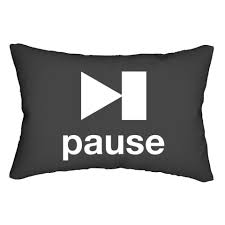

### Model Experimentation

For the second part of our lab, we will perform:

- **Model Comparison**: Evaluate different LLMs
- **Parameter Experimentation**: Experiment with temperature, top_p and other parameter settings
- **Advanced Techniques**: Practice zero-shot, few-shot, and Chain-of-Thought prompting

**Model Comparison**

Let's start by comparing Gemini's `gemini-2.0-flash` with Gemini's `gemini-2.5-flash`.

Check to see if the responses differ at all from the previous responses you received.

In [ ]:
available_models_df['Model Name'].values

array(['gemini/gemini-1.5-flash', 'gemini/gemini-1.5-flash-002',
       'gemini/gemini-1.5-flash-latest', 'gemini/gemini-2.0-flash',
       'gemini/gemini-2.0-flash-001', 'gemini/gemini-2.0-flash-lite',
       'gemini/gemini-2.0-flash-lite-preview-02-05',
       'gemini/gemini-2.5-flash', 'gpt-4.1-mini',
       'gpt-4.1-mini-2025-04-14', 'gpt-4.1-nano',
       'gpt-4.1-nano-2025-04-14', 'gpt-5-mini', 'gpt-5-mini-2025-08-07',
       'gpt-5-nano', 'gpt-5-nano-2025-08-07'], dtype=object)

In [ ]:
prompt_to_test = "What is the biggest animal in the world?"



gemini_2_0_flash_response = completion(model='gemini/gemini-2.0-flash',temperature=0.8,
                      messages=[{'role': 'user', 'content': prompt_to_test}])

gemini_2_5_flash_response = completion(model='gemini/gemini-2.5-flash',temperature=0.8,
                      messages=[{'role': 'user', 'content': prompt_to_test}])

print("Gemini-2.0-flash response:")
display(Markdown(gemini_2_0_flash_response.choices[0].message.content))
print("Gemini-2.5-flash response:")
display(Markdown(gemini_2_5_flash_response.choices[0].message.content))


Gemini-2.0-flash response:


The biggest animal in the world is the **blue whale** ( *Balaenoptera musculus*).


Gemini-2.5-flash response:


The biggest animal in the world is the **blue whale**.

It is the largest animal known to have ever lived, by both length and weight.

*   **Length:** Up to 30 meters (100 feet) – roughly the length of three school buses.
*   **Weight:** Up to 200 tons (400,000 pounds) – equivalent to about 30 elephants.

**PAUSE**, and consider the above. Play with it! Try other questions!

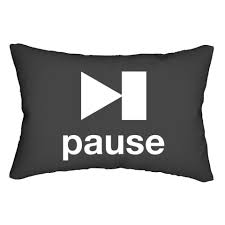

### Parameter Experimentation

Try simple things like changing the temperature of the model.

In [ ]:
for temperature in [0, 0.5, 1]:
  print(f"Temperature = {temperature}:")
  response = completion(model='gemini/gemini-2.0-flash',temperature=temperature,
                      messages=[{'role': 'user', 'content': "Why is the sky blue? Answer in 30 words or less"}])
  display(Markdown(response.choices[0].message.content))

Temperature = 0:


The sky is blue because of Rayleigh scattering. Air molecules scatter blue light from the sun more than other colors, making the sky appear blue in all directions.


Temperature = 0.5:


The sky is blue because of Rayleigh scattering. Blue light from the sun is scattered more by the Earth's atmosphere than other colors, making the sky appear blue.


Temperature = 1:


The sky is blue because of a phenomenon called Rayleigh scattering. Air molecules scatter blue light from the sun more than other colors, making the sky appear blue.


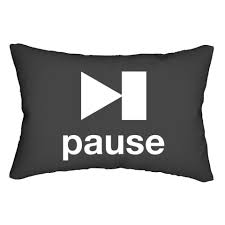

**PAUSE** here. What did you notice about the different temperature settings?

### Advanced Techniques

Practice zero-shot, few-shot, and Chain-of-Thought prompting.

**Zero-Shot Prompting**

Zero-shot prompting occurs when a model is asked to perform a task without any prior examples or context about how to perform that specific task. The prompt must be self-contained, as the model relies solely on its pre-trained knowledge to generate a response.

Example Prompt:
* Summarize the key impacts of the 2020 global pandemic on remote work trends.

In this case, the model is expected to understand what is being asked and use its internal knowledge to provide a summary without any additional examples or guidance.


In [ ]:
# try zero-shot
prompt = "Summarize the top 3 key impacts of the 2020 global pandemic on remote work trends."
res_zero = completion(model='gemini/gemini-2.5-flash',temperature=1,
                      messages=[{'role': 'user', 'content': prompt}])

display(Markdown(res_zero.choices[0].message.content))

The 2020 global pandemic profoundly reshaped remote work trends, leading to three key impacts:

1.  **Rapid, Widespread Adoption and Normalization:** Remote work shifted almost overnight from a niche benefit or occasional flexibility to a mandatory, mainstream mode of operation for countless businesses. This forced immediate adoption, proving its viability on a massive scale and fundamentally changing perceptions of its effectiveness.
2.  **Significant Investment in Enabling Technology and Policy Frameworks:** To support the sudden shift, companies poured resources into collaborative software, secure remote access, cloud infrastructure, and video conferencing tools. Simultaneously, new HR policies, management strategies, and communication protocols were developed to manage distributed teams effectively.
3.  **Emergence of Hybrid Models and Expanded Talent Pools:** While not all companies remained fully remote, the pandemic cemented the viability of flexible work. This led to a widespread adoption of "hybrid" models, combining in-office and remote days. Crucially, it also dissolved geographic barriers for many roles, allowing companies to tap into a much broader, global talent pool and employees to seek opportunities beyond their local area.


**Few-Shot Prompting**

Few-shot prompting involves providing a few examples to the model before presenting the actual task. This approach helps the model understand the desired format or the specific type of response needed.

Example Prompt:

```
Example 1: Translate the English phrase "Hello, how are you?" to French.
Answer: Bonjour, comment ça va?

Example 2: Translate the English phrase "What time is it?" to French.
Answer: Quelle heure est-il?

Prompt: Translate the English phrase "Where is the nearest restaurant?" to French.
```

Here, the model is shown two examples of translation tasks, which sets the expectation that it should translate the third phrase from English to French in a similar format.

In [ ]:
# try few-shot prompting
prompt = """
  Below are a few examples, followed by the prompt for you to follow.

  Example 1: Translate the English phrase "Hello, how are you?" to French.
  Answer: Bonjour, comment ça va?

  Example 2: Translate the English phrase "What time is it?" to French.
  Answer: Quelle heure est-il?

  Prompt: Translate the English phrase "Where is the nearest restaurant?" to French."""

res_few = completion(model='gemini/gemini-2.5-flash',temperature=1,
                    messages=[{'role': 'user', 'content': prompt}])

display(Markdown(res_few.choices[0].message.content))

Answer: Où est le restaurant le plus proche?

**Chain-of-Thought Prompting**

Chain-of-Thought prompting guides the model through a logical sequence of steps or thoughts to reach a conclusion, particularly useful for complex reasoning tasks. This method helps models handle problems that require multiple inferential steps.

Example Prompt:

```
Question: A farmer has 17 sheep, and all but 9 die. How many are left alive?
Chain of Thought: The phrase "all but 9 die" means that 9 sheep remain alive.
Answer: 9
```

In this example, the prompt explicitly outlines the reasoning process needed to answer the question, leading the model to the correct interpretation and response.

In [ ]:
# try chain-of-thought prompting
prompt = """
  I will pose a question, and you will provide your chain-of-thought reasoning to reach the answer.

  Question: A farmer has 17 sheep, and all but 9 die. How many are left alive?"""

res_cot = completion(model='gemini/gemini-2.0-flash-lite',temperature=1,
                    messages=[{'role': 'user', 'content': prompt}])

display(Markdown(res_cot.choices[0].message.content))


Here's my chain of thought:

1. **The problem states "all but 9 die."** This phrase indicates that only 9 sheep survived the event.
2. **The question asks how many are left alive.**
3. **Therefore, the answer is 9.**


**Usage Tips:**

* **Zero-Shot**: Useful when querying general knowledge or opinions, or when the task is straightforward.
* **Few-Shot**: Effective for tasks that require specific formats or where a model needs examples to "learn" the task quickly.
* **Chain-of-Thought**: Best for complex reasoning, mathematics, or multi-step logical problems.

## 3. AI Safety Challenge

For the third and final part of this lab, we will do a:

- **Prompt Hacking Exercise**: Test the limits of AI safety with the Gandalf challenge*
  - URL: https://gandalf.lakera.ai/baseline
  - Objective: Attempt to "hack" the AI chatbot using creative prompting techniques
  - Time: Utilize any remaining lab time to see if you can get through all of the levels!

*Note: For further exploration, look into safety tools like Meta's Prompt Guard and LLaMA Guard.
